In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
import numpy as np

In [2]:
trainPath = r'dataset\train.csv'
testPath = r'dataset\test.csv'

In [3]:
trainData = pd.read_csv(trainPath)
trainData

,ID,electricity_kwh_per_month,natural_gas_therms_per_month,vehicle_miles_per_month,house_area_sqft,water_usage_liters_per_day,public_transport_usage_per_week,household_size,home_insulation_quality,meat_consumption_kg_per_week,laundry_loads_per_week,recycles_regularly,composts_organic_waste,uses_solar_panels,energy_efficient_appliances,heating_type,diet_type,owns_pet,smart_thermostat_installed,carbon_footprint
0,0xd6c,759.70,55.95,944.55,2422.07,541.27,1,3,2,4.23,9,1.0,0.0,0,1.0,gas,vegetarian,1,NaN,830.10
1,0x3fdf,387.06,70.59,1280.85,1995.3,280.39,1,2,1,3.27,8,0.0,0.0,0,0.0,electric,vegetarian,0,0.0,963.08
2,0x3b08,594.25,29.14,1005.72,2673.55,416.14,0,2,3,2.87,3,0.0,1.0,0,1.0,electric,omnivore,1,1.0,840.11
3,0x31e5,503.76,74.68,1049.46,2994.28,530.13,0,5,1,3.22,9,1.0,0.0,0,0.0,electric,omnivore,1,0.0,1252.42
4,0x397e,549.54,-77.00,756.49,2549.57,604.10,5,4,4,2.92,2,1.0,0.0,0,1.0,electric,vegetarian,0,1.0,580.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0x4aaa,324.96,43.37,438.36,1514.05,419.48,3,1,2,3.17,7,0.0,0.0,0,0.0,electric,omnivore,1,1.0,865.07
13996,0x36c3,581.19,83.50,1865.29,3357.9,651.11,0,1,3,6.60,3,1.0,1.0,0,0.0,gas,omnivore,1,0.0,1594.70
13997,0x3846,302.76,43.36,212.42,939.08,343.67,9,1,2,3.07,3,1.0,0.0,1,0.0,gas,omnivore,1,1.0,712.94
13998,0x4ba4,397.77,14.80,592.66,1164.04,271.67,2,7,0,2.48,4,1.0,0.0,1,0.0,gas,vegetarian,0,0.0,533.65


## **EDA**

In [4]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14000 non-null  object 
 1   electricity_kwh_per_month        14000 non-null  float64
 2   natural_gas_therms_per_month     14000 non-null  float64
 3   vehicle_miles_per_month          14000 non-null  float64
 4   house_area_sqft                  14000 non-null  object 
 5   water_usage_liters_per_day       14000 non-null  float64
 6   public_transport_usage_per_week  14000 non-null  int64  
 7   household_size                   14000 non-null  object 
 8   home_insulation_quality          14000 non-null  int64  
 9   meat_consumption_kg_per_week     14000 non-null  float64
 10  laundry_loads_per_week           14000 non-null  int64  
 11  recycles_regularly               13590 non-null  float64
 12  composts_organic_w

In [5]:
trainData.energy_efficient_appliances.unique()

array([ 1.,  0., nan])

In [6]:
trainData.owns_pet.unique()

array([1, 0])

In [7]:
trainData.carbon_footprint.min()

np.float64(310.0)

In [8]:
def outliers(df : pd.DataFrame, column_name : str):
    df_in = df.copy()

    Q1 = df_in[column_name].quantile(0.25)
    Q3 = df_in[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_in[(df_in[column_name] < lower_bound) |
                    (df_in[column_name] > upper_bound)]
    
    plt.figure(figsize=(20, 5))
    plt.boxplot(trainData[column_name] , vert=False)
    plt.show()

    print("Outliers:")
    print(outliers[[column_name]])

    return upper_bound, lower_bound


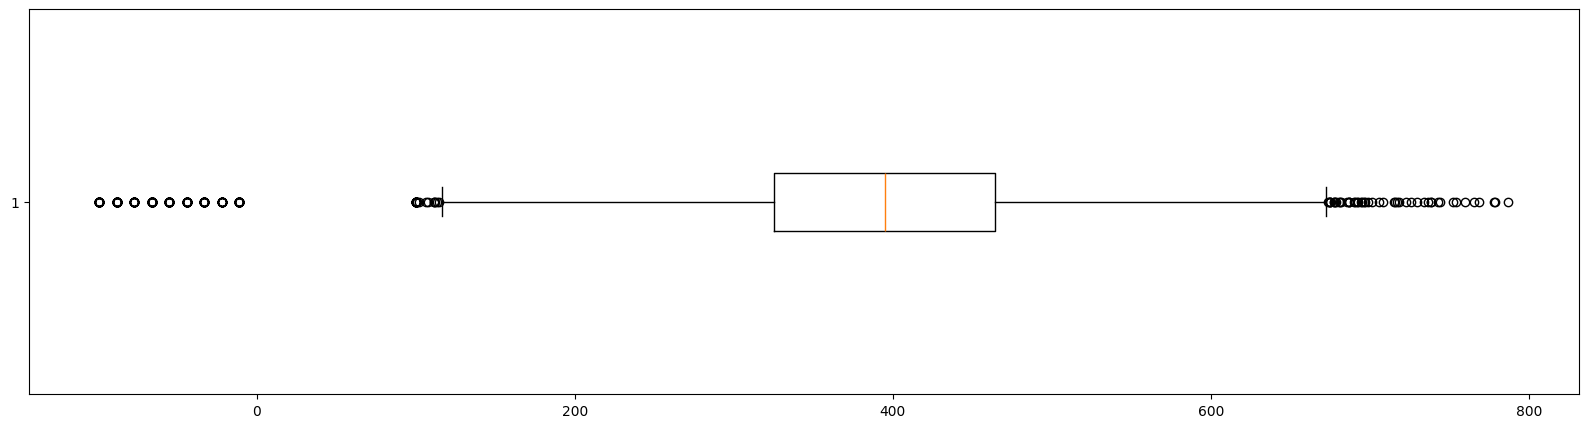

Outliers:
       electricity_kwh_per_month
0                         759.70
40                        -55.00
69                        -88.00
94                        -33.00
126                       -77.00
...                          ...
13853                     -77.00
13876                     -99.00
13977                     -11.00
13983                     696.77
13987                     -77.00

[369 rows x 1 columns]


In [9]:
upper_bound_elec, lower_bound_elec = outliers(trainData, 'electricity_kwh_per_month')

A important question arises here that is should we remove these outliers, since electricity usage can vary from house to house and high usage may not neccesarily be outliers but just characterstic of the data.

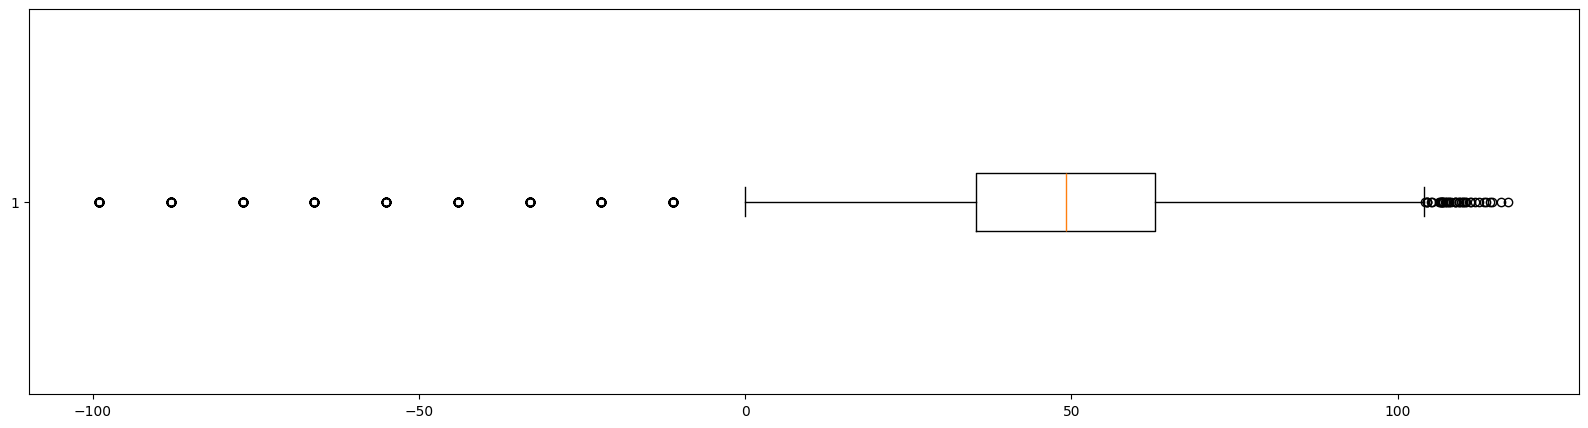

Outliers:
       natural_gas_therms_per_month
4                            -77.00
72                           -11.00
104                          -33.00
131                          -66.00
152                          -33.00
...                             ...
13893                        104.45
13907                        107.29
13922                        -77.00
13952                        -44.00
13954                        -99.00

[331 rows x 1 columns]


In [10]:
upper_bound_gas, lower_bound_gas = outliers(trainData, 'natural_gas_therms_per_month')

In [11]:
trainData.natural_gas_therms_per_month = trainData.natural_gas_therms_per_month.clip(lower=0)

A point could be made here also, but gas usage can't be a negative value.

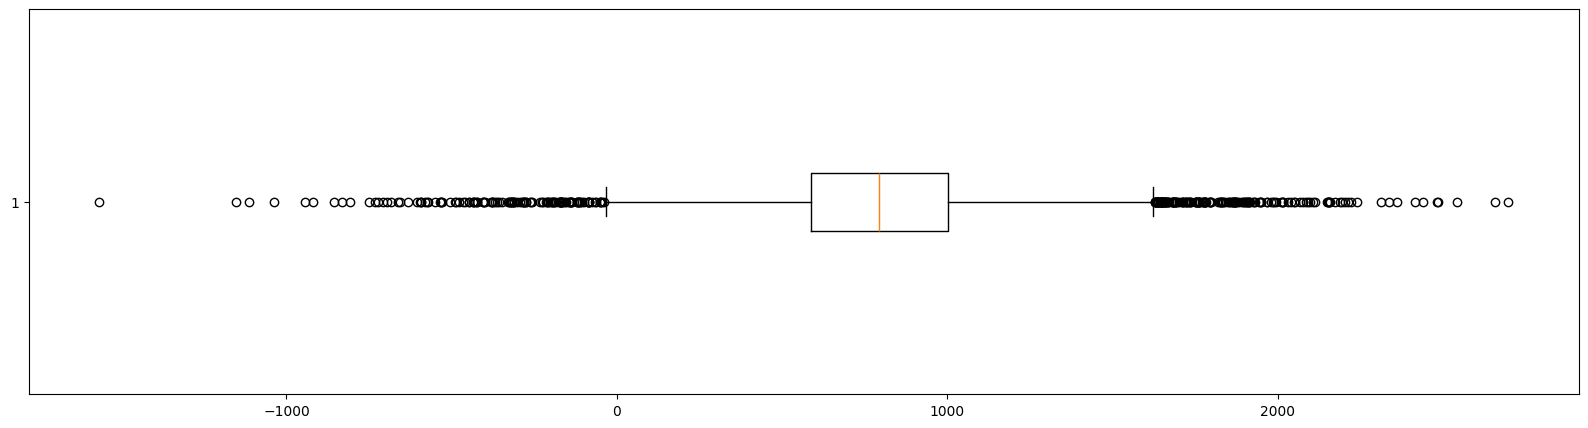

Outliers:
       vehicle_miles_per_month
17                 1645.640000
55                 -209.101901
66                 1794.484160
118                2155.209928
154                1876.046083
...                        ...
13812              1883.763297
13900              -213.728563
13911              1872.494028
13959              -662.695119
13996              1865.290000

[312 rows x 1 columns]


In [12]:
upper_bound_gas, lower_bound_gas = outliers(trainData, 'vehicle_miles_per_month')

In [13]:
trainData.vehicle_miles_per_month = trainData.vehicle_miles_per_month.clip(lower=0)

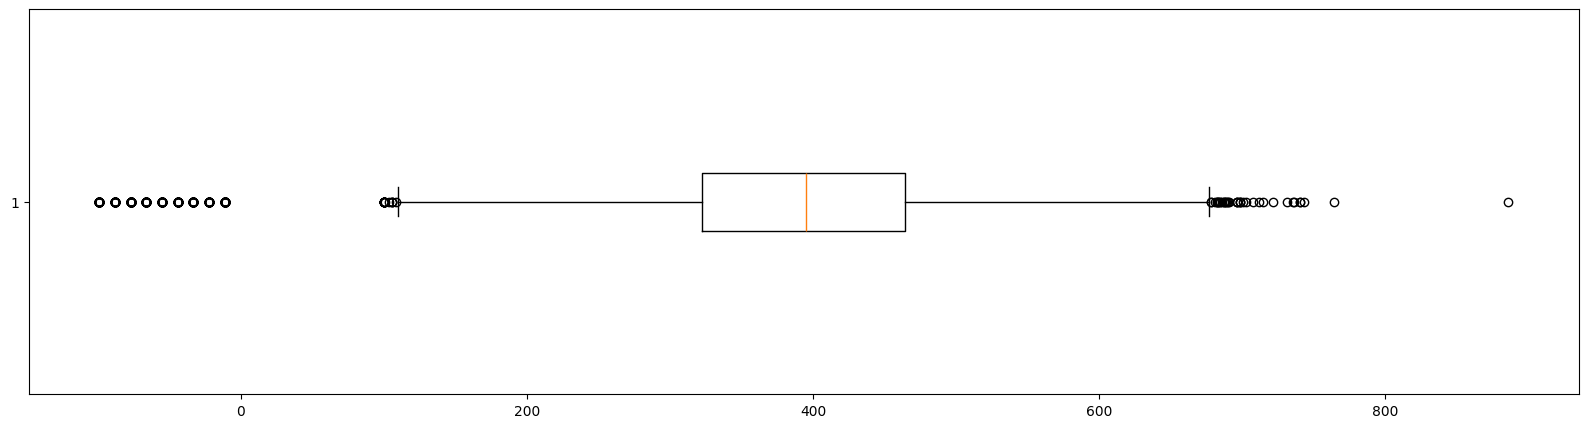

Outliers:
       water_usage_liters_per_day
12                         -55.00
50                         -66.00
51                         -88.00
74                         -11.00
84                         -55.00
...                           ...
13901                      -44.00
13915                      -88.00
13959                      -33.00
13975                      690.41
13991                      103.49

[488 rows x 1 columns]


In [14]:
upper_bound_water, lower_bound_water = outliers(trainData, 'water_usage_liters_per_day')

In [15]:
trainData.water_usage_liters_per_day = trainData.water_usage_liters_per_day.abs()

Can't be living without water

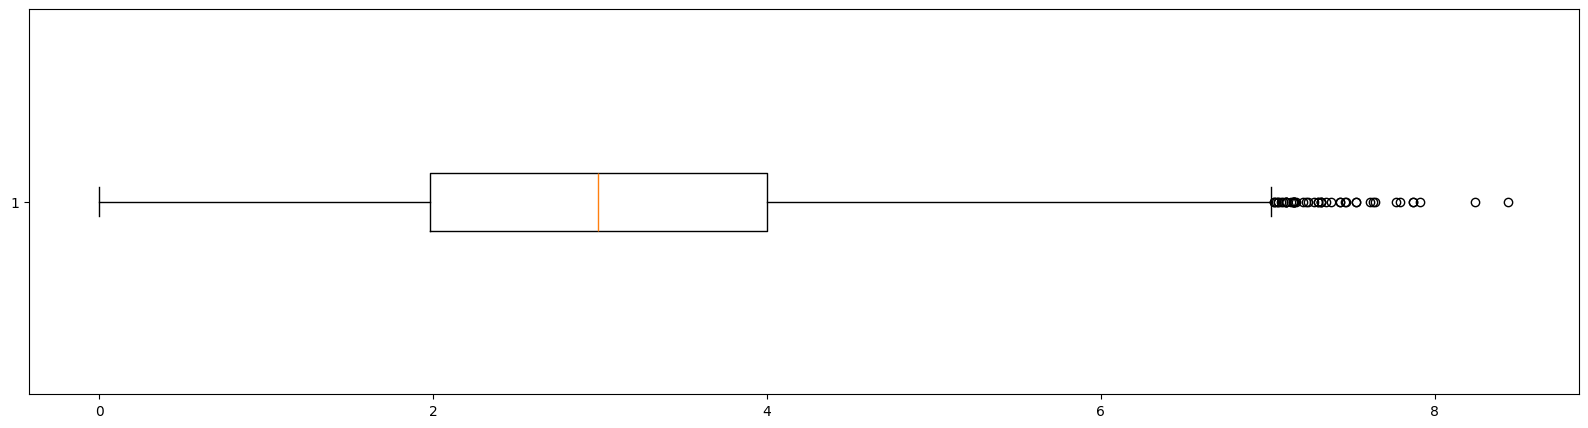

Outliers:
       meat_consumption_kg_per_week
276                            7.04
364                            7.87
784                            7.46
806                            7.06
1302                           7.43
1390                           7.15
2128                           7.05
2365                           7.14
2517                           7.30
2581                           7.11
2596                           7.43
2759                           8.24
3151                           7.32
3300                           7.32
4060                           7.16
4092                           7.17
4438                           7.53
4673                           7.79
4722                           7.38
4754                           7.47
4771                           7.53
5272                           7.91
5661                           7.11
5929                           7.87
6103                           7.28
6125                           7.23
6147              

In [16]:
upper_bound_meat, lower_bound_meat = outliers(trainData, 'meat_consumption_kg_per_week')

Could be due to more Members in the household

In [17]:
def draw_pie(series: pd.Series, figsize: tuple = (7.5, 7.5), title : str = None, ax=None):
    values = series.value_counts()
    labels = values.index
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.set_title(title)

def plot_bar(x, height, title : str = None, y_label : str = None, x_label : str = None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))

    bars = ax.bar(x, height, color='royalblue', edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:,.0f}", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

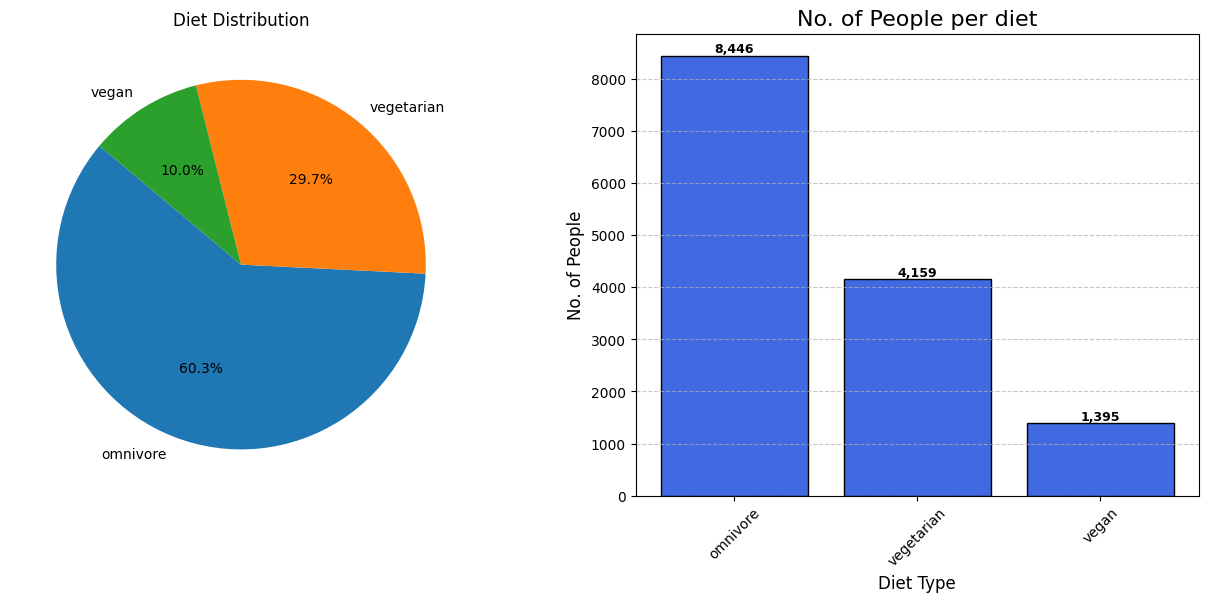

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

draw_pie(trainData.diet_type, title= 'Diet Distribution', ax=axes[0])
plot_bar(trainData.diet_type.value_counts().index, trainData.diet_type.value_counts().values, ax = axes[1], title='No. of People per diet', x_label= 'Diet Type', y_label='No. of People')

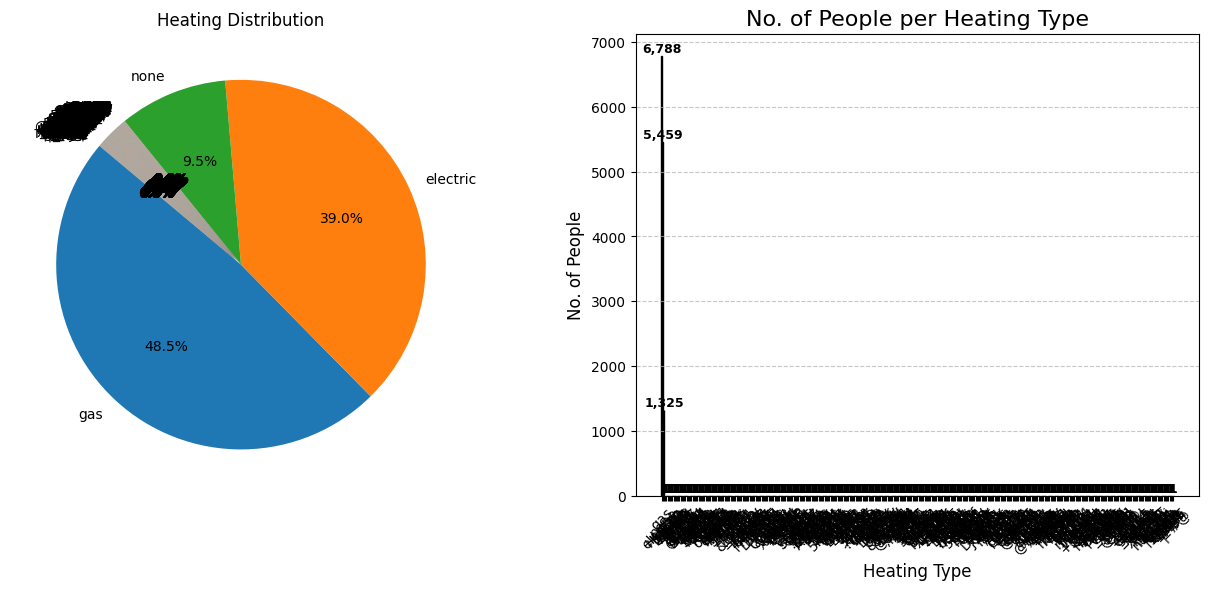

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

draw_pie(trainData.heating_type, title= 'Heating Distribution', ax=axes[0])
plot_bar(trainData.heating_type.value_counts().index, trainData.heating_type.value_counts().values, ax = axes[1], title='No. of People per Heating Type', x_label= 'Heating Type', y_label='No. of People')

Heating Type has a lot of Noise so better to drop it.

## **Data Preprocessing & Feature Engineering**

In [20]:
def convert_to_object(df):
    """Convert environmental behavior flags to 'yes'/'no' categorical strings."""
    df_in = df.copy()
    columns = [
        'recycles_regularly',
        'composts_organic_waste',
        'smart_thermostat_installed',
        'uses_solar_panels',
        'energy_efficient_appliances',
        'owns_pet'
    ]
    for col in columns:
        df_in[col] = df_in[col].apply(lambda x: 'yes' if x == 1.0 else ('no' if x == 0.0 else np.nan)).astype('object')
    return df_in

def convert_to_float(df):
    """Convert household_size and house_area_sqft to floats safely."""
    df_in = df.copy()
    df_in['house_area_sqft'] = pd.to_numeric(df_in['house_area_sqft'], errors='coerce')
    df_in['household_size'] = pd.to_numeric(df_in['household_size'], errors='coerce')
    return df_in

def drop_heating_type(df):
    """Drop the heating_type column."""
    df_in = df.copy()
    if 'heating_type' in df_in.columns:
        df_in = df_in.drop(columns=['heating_type'])
    return df_in

In [21]:
def calculate_total_resource_consumption(df):
    """Calculate total resource consumption per day and add a new column."""
    df_in = df.copy()
    df_in['electricity_per_day'] = df_in['electricity_kwh_per_month'] / 30
    df_in['natural_gas_per_day'] = df_in['natural_gas_therms_per_month'] / 30
    df_in['vehicle_miles_per_day'] = df_in['vehicle_miles_per_month'] / 30
    df_in['total_resource_per_day'] = (df_in['electricity_per_day'] + 
                                    df_in['natural_gas_per_day'] + 
                                    df_in['vehicle_miles_per_day'] + 
                                    df_in['water_usage_liters_per_day'])
    return df_in

def calculate_energy_efficiency(df):
    """Calculate a basic energy efficiency score and add a new column."""
    df_in = df.copy()
    df_in['energy_efficiency_score'] = (
        (df_in['home_insulation_quality'].fillna(0) / 5) +  
        df_in['energy_efficient_appliances'].fillna(0) + 
        df_in['smart_thermostat_installed'].fillna(0) + 
        df_in['uses_solar_panels'].fillna(0)
    ) / 4  
    return df_in

def calculate_resource_usage_per_person(df):
    """Calculate resource usage per person (electricity, water, vehicle, etc.)."""
    df_in = df.copy()
    df_in['electricity_per_person'] = df_in['electricity_kwh_per_month'] / df_in['household_size']
    df_in['water_per_person'] = df_in['water_usage_liters_per_day'] / df_in['household_size']
    df_in['vehicle_miles_per_person'] = df_in['vehicle_miles_per_month'] / df_in['household_size']
    return df_in

def calculate_sustainability_index(df):
    """Calculate sustainability index based on eco-friendly behaviors."""
    df_in = df.copy()
    df_in['sustainability_index'] = (
        df_in['recycles_regularly'].fillna(0) + 
        df_in['composts_organic_waste'].fillna(0) + 
        df_in['uses_solar_panels'].fillna(0) + 
        df_in['energy_efficient_appliances'].fillna(0) +
        df_in['diet_type'].apply(lambda x: 1 if x in ['vegan', 'vegetarian'] else 0)
    )
    return df_in

def calculate_renewable_adoption_flag(df):
    """Create a flag indicating renewable energy adoption (solar panels)."""
    df_in = df.copy()
    df_in['renewable_adoption_flag'] = (df_in['uses_solar_panels'] == 1) & (df_in['energy_efficient_appliances'] == 1)
    return df_in

def calculate_eco_consciousness_level(df):
    """Count the number of 'yes' responses for eco-friendly behaviors."""
    df_in = df.copy()
    df_in['eco_consciousness_level'] = (
        df_in['recycles_regularly'].fillna(0) + 
        df_in['composts_organic_waste'].fillna(0) + 
        df_in['uses_solar_panels'].fillna(0) + 
        df_in['energy_efficient_appliances'].fillna(0) + 
        df_in['smart_thermostat_installed'].fillna(0)
    )
    return df_in

def calculate_transport_impact(df):
    """Estimate environmental impact from personal and public transport."""
    df_in = df.copy()
    df_in['transport_impact_score'] = (
        df_in['vehicle_miles_per_month'] * 0.79 / 1000  
        - df_in['public_transport_usage_per_week'] * 4 * 0.105  
    )
    return df_in

In [22]:
X = trainData.copy().drop(columns=['carbon_footprint', 'ID'])
Y = trainData.carbon_footprint

In [23]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [161]:
feature_pipeline = Pipeline([
    ('drop_heating_type', FunctionTransformer(drop_heating_type)),
    ('convert_float', FunctionTransformer(convert_to_float)),
    #('add_energy_efficiency', FunctionTransformer(calculate_energy_efficiency)),
    #('add_resource_usage_per_person', FunctionTransformer(calculate_resource_usage_per_person)),
    #('add_sustainability_index', FunctionTransformer(calculate_sustainability_index)),
    #('add_total_resource_consumption', FunctionTransformer(calculate_total_resource_consumption)),
    #('add_eco_conscious_level', FunctionTransformer(calculate_eco_consciousness_level)),
    #('add_renewable_adoption_flag', FunctionTransformer(calculate_renewable_adoption_flag)),
    #('add_tranport_impact', FunctionTransformer(calculate_transport_impact)),
    ('convert_object', FunctionTransformer(convert_to_object))
]).set_output(transform='pandas')

In [162]:
Xfeatured = feature_pipeline.fit_transform(X)

In [163]:
Xfeatured

,electricity_kwh_per_month,natural_gas_therms_per_month,vehicle_miles_per_month,house_area_sqft,water_usage_liters_per_day,public_transport_usage_per_week,household_size,home_insulation_quality,meat_consumption_kg_per_week,laundry_loads_per_week,recycles_regularly,composts_organic_waste,uses_solar_panels,energy_efficient_appliances,diet_type,owns_pet,smart_thermostat_installed
0,759.70,55.95,944.55,2422.07,541.27,1,3.0,2,4.23,9,yes,no,no,yes,vegetarian,yes,NaN
1,387.06,70.59,1280.85,1995.30,280.39,1,2.0,1,3.27,8,no,no,no,no,vegetarian,no,no
2,594.25,29.14,1005.72,2673.55,416.14,0,2.0,3,2.87,3,no,yes,no,yes,omnivore,yes,yes
3,503.76,74.68,1049.46,2994.28,530.13,0,5.0,1,3.22,9,yes,no,no,no,omnivore,yes,no
4,549.54,0.00,756.49,2549.57,604.10,5,4.0,4,2.92,2,yes,no,no,yes,vegetarian,no,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,324.96,43.37,438.36,1514.05,419.48,3,1.0,2,3.17,7,no,no,no,no,omnivore,yes,yes
13996,581.19,83.50,1865.29,3357.90,651.11,0,1.0,3,6.60,3,yes,yes,no,no,omnivore,yes,no
13997,302.76,43.36,212.42,939.08,343.67,9,1.0,2,3.07,3,yes,no,yes,no,omnivore,yes,yes
13998,397.77,14.80,592.66,1164.04,271.67,2,7.0,0,2.48,4,yes,no,yes,no,vegetarian,no,no


In [164]:
categorical_columns = Xfeatured.select_dtypes(include=['object','category']).columns
numerical_columns = Xfeatured.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
    ('num', numerical_transformer, numerical_columns),
    ('categorical', categorical_transformer, categorical_columns)
], remainder='passthrough', sparse_threshold=0)

In [165]:
preprocessor_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [166]:
Xtransform = preprocessor_pipeline.fit_transform(Xfeatured)

In [167]:
Xtransform.shape

(14000, 25)

In [189]:
YNormalized = np.log(Y.values) - np.mean(np.log(Y.values))

In [190]:
x_train, x_val, y_train, y_val = train_test_split(Xtransform, YNormalized, test_size=0.2, random_state=42)

In [191]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(11200, 25)
(11200,)
(2800, 25)
(2800,)


## **Linear Regression**

In [192]:
linear = LinearRegression()

linear.fit(x_train, y_train)

LinearRegression()

In [193]:
val_predictions_lr = linear.predict(x_val)

print(mse(y_val, val_predictions_lr))
print(r2(y_val, val_predictions_lr))

0.007406442827326916
0.8841437352310078


In [194]:
testData = pd.read_csv(testPath)

In [195]:
testfeatured = feature_pipeline.transform(testData)
x_test = preprocessor_pipeline.transform(testfeatured)

In [196]:
predictions_linear = linear.predict(x_test)
predictions_linear = np.exp(predictions_linear + 6.5)
submission_linear = testData[['ID']].copy()

submission_linear['carbon_footprint'] = predictions_linear
submission_linear.to_csv(r'submissions\SubmissionLR.csv', index=False)

In [198]:
select = set([29, 8, 2, 1, 30, 10, 27, 7, 0, 9, 14, 3, 31, 21, 17, 23, 16, 28])

mask = []

for i in range(37):
    mask.append(1) if i in select else mask.append(0)

## **XGBoost**

In [200]:
xgb = XGBRegressor(tree_method='hist', objective='reg:squarederror', random_state=42, device='cuda')

In [201]:
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'tree_method': 'gpu_hist',  
        'predictor': 'gpu_predictor',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 5e-1, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    model = XGBRegressor(**param)
    model.fit(x_train, y_train)

    preds = model.predict(x_val)
    return mse(y_val, preds)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-05-04 21:49:33,836] A new study created in memory with name: no-name-0e440ede-b65c-48f4-88aa-2e200973932e
[I 2025-05-04 21:49:37,026] Trial 0 finished with value: 0.0427587607537083 and parameters: {'n_estimators': 946, 'max_depth': 6, 'learning_rate': 0.000341131836500997, 'colsample_bytree': 0.7295717716939089, 'reg_alpha': 0.3048920151908716, 'reg_lambda': 0.1949972813707176}. Best is trial 0 with value: 0.0427587607537083.
[I 2025-05-04 21:49:37,490] Trial 1 finished with value: 0.007638738874723932 and parameters: {'n_estimators': 197, 'max_depth': 5, 'learning_rate': 0.40138203958211255, 'colsample_bytree': 0.8446117528758089, 'reg_alpha': 0.708907500127412, 'reg_lambda': 0.7482656346753145}. Best is trial 1 with value: 0.007638738874723932.
[I 2025-05-04 21:49:39,219] Trial 2 finished with value: 0.006259737346352198 and parameters: {'n_estimators': 940, 'max_depth': 4, 'learning_rate': 0.02570570658700399, 'colsample_bytree': 0.771310774353656, 'reg_alpha': 0.7353542736

Best params: {'n_estimators': 962, 'max_depth': 3, 'learning_rate': 0.05426512731456278, 'colsample_bytree': 0.8486271345266282, 'reg_alpha': 0.5830708196277606, 'reg_lambda': 0.562629303934514}
Best RMSE: 0.006132040817553539


In [202]:
pramas = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist', 
        'device': 'cuda', 
        'predictor': 'gpu_predictor',
        'n_estimators': 962, 
        'max_depth': 3, 
        'learning_rate': 0.05426512731456278, 
        'colsample_bytree': 0.8486271345266282, 
        'reg_alpha': 0.5830708196277606, 
        'reg_lambda': 0.562629303934514}

optuna_xgb = XGBRegressor(**pramas)
optuna_xgb.fit(x_train, y_train)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:57:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8486271345266282, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05426512731456278,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=962, n_jobs=None,
             num_parallel_tree=None, ...)

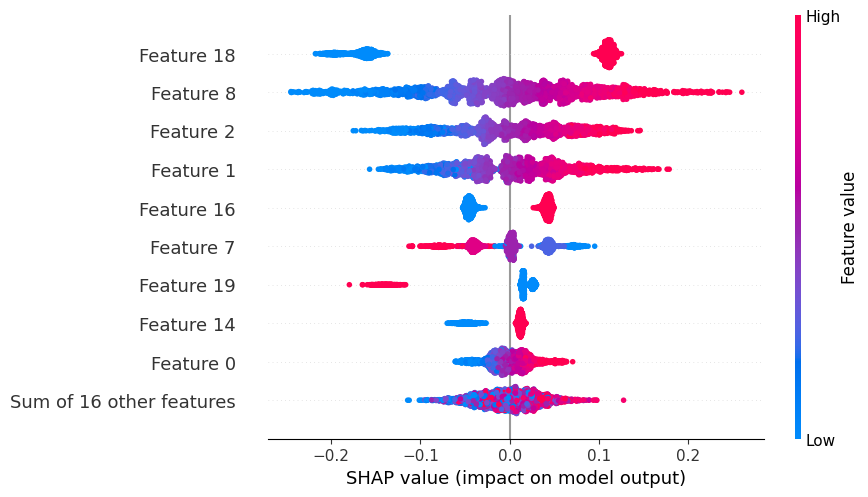

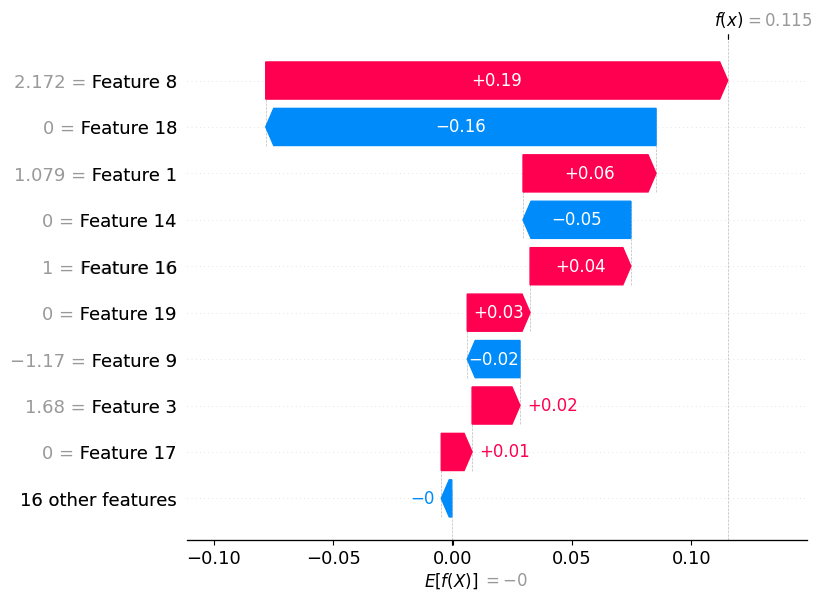

In [204]:
import shap
explainer = shap.Explainer(optuna_xgb)
shap_values = explainer(x_val)

shap.plots.beeswarm(shap_values)  
shap.plots.waterfall(shap_values[0])

In [207]:
val_predictions_xgb = optuna_xgb.predict(x_val)

print(mse(y_val, val_predictions_xgb))
print(r2(y_val, val_predictions_xgb))

0.006132040817553539
0.9040787377833367


In [42]:
search_spaces = {
    'learning_rate': Real(1e-4, 5e-1, prior='log-uniform'),
    'max_depth': Integer(3, 7),
    'min_child_weight': Integer(1, 10),
    'colsample_bytree': Real(0.7, 1.0),
    'reg_alpha': Real(0.1, 1.0),
    'reg_lambda': Real(0.0, 1.0),
    'n_estimators': Integer(50, 350)
}

opt = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

opt.fit(x_train, y_train)

best_model = opt.best_estimator_
y_pred = best_model.predict(x_val)
print("MSE:", mse(y_val, y_pred))
print("Best Params:", opt.best_params_)

MSE: 0.0063102380092759204
Best Params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.13531704132066602), ('max_depth', 3), ('min_child_weight', 1), ('n_estimators', 194), ('reg_alpha', 1.0), ('reg_lambda', 0.0)])


In [43]:
val_predictions_best_model = best_model.predict(x_val)

print(mse(y_val, val_predictions_best_model))
print(r2(y_val, val_predictions_best_model))

0.0063102380092759204
0.90129126456487


In [214]:
predictions_xgb = optuna_xgb.predict(x_test)
predictions_xgb = np.exp(predictions_xgb + np.mean(np.log(Y.values)))
submission_xgb = testData[['ID']].copy()

submission_xgb['carbon_footprint'] = predictions_xgb
submission_xgb.to_csv(r'submissions\SubmissionXGBOptuna.csv', index=False)

## **NN**

In [42]:
print(x_train.dtype, y_train.dtype)

x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

x_val = np.array(x_val).astype(np.float32)
y_val = np.array(y_val).astype(np.float32)


train_tensor = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(256).prefetch(tf.data.AUTOTUNE)
val_tensor = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(256).prefetch(tf.data.AUTOTUNE)

float64 float64


In [ ]:
def create_model(trial):
    model = tf.keras.Sequential()
    
    num_hidden = trial.suggest_int(f'n_units_l_1', 150, 650)
    model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
    dropout_rate = trial.suggest_float(f'dropout_l', 0.0, 0.3)
    if dropout_rate > 0:
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(1))  

    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss='mse', optimizer=optimizer)
    return model


def objective(trial):
    model = create_model(trial)
    
    history = model.fit(
        train_tensor,
        validation_data=val_tensor,
        epochs=50,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    )

    y_pred = model.predict(x_val).flatten()
    return mse(y_val, y_pred)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print("  Value (MSE):", trial.value)
print("  Params:", trial.params)

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(416, activation='relu'),
    tf.keras.layers.Dropout(0.2692766351124277),
    tf.keras.layers.Dense(76, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0039414547648810375),
              metrics=['mse', 'r2_score'])

In [38]:
model.fit(train_tensor,
          validation_data=val_tensor,
          epochs=75,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0775 - mse: 0.0775 - r2_score: -0.2275 - val_loss: 0.0095 - val_mse: 0.0095 - val_r2_score: 0.8509
Epoch 2/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - mse: 0.0111 - r2_score: 0.8232 - val_loss: 0.0075 - val_mse: 0.0075 - val_r2_score: 0.8832
Epoch 3/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - mse: 0.0095 - r2_score: 0.8488 - val_loss: 0.0071 - val_mse: 0.0071 - val_r2_score: 0.8889
Epoch 4/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - mse: 0.0088 - r2_score: 0.8605 - val_loss: 0.0068 - val_mse: 0.0068 - val_r2_score: 0.8931
Epoch 5/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - mse: 0.0085 - r2_score: 0.8642 - val_loss: 0.0067 - val_mse: 0.0067 - val_r2_score: 0.8948
Epoch 6/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - mse: 0.0081 - r2_score: 0.8713 - val_loss: 0.0067 - val_mse: 0.0067 - val_r2_score: 0.8956
Epoch 7/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

In [39]:
predictions_NN = model.predict(x_test)
predictions_NN = np.exp(predictions_NN + 6.5)
submission_NN = testData[['ID']].copy()

submission_NN['carbon_footprint'] = predictions_NN
submission_NN.to_csv(r'submissions\SubmissionNN.csv', index=False)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


## **LightGBM**

In [60]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [208]:
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'device': 'gpu', 
        'verbosity': -1,
        'max_bin':255,
        'learning_rate': trial.suggest_float('learning_rate', 5e-3, 5e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 1024),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 250),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
    }
    
    model = LGBMRegressor(**param)
        
    model.fit(np.array(x_train), np.array(y_train))

    y_pred = model.predict(x_val)
    return mse(y_val, y_pred)
     

study = optuna.create_study(direction="minimize")  
study.optimize(objective, n_trials=100)  

print("Best params:", study.best_params)
print("Best MSE:", study.best_value)


[I 2025-05-04 22:00:14,707] A new study created in memory with name: no-name-5f9275fc-f846-49de-a06f-3c8ce3d66bb5
[I 2025-05-04 22:00:17,485] Trial 0 finished with value: 0.007390006119383343 and parameters: {'learning_rate': 0.23034354093893208, 'num_leaves': 551, 'max_depth': 6, 'min_child_samples': 16, 'colsample_bytree': 0.8359109959941932, 'reg_alpha': 0.17993001831297972, 'reg_lambda': 0.0006587616663969973, 'n_estimators': 428}. Best is trial 0 with value: 0.007390006119383343.
[I 2025-05-04 22:00:21,007] Trial 1 finished with value: 0.006920411913236002 and parameters: {'learning_rate': 0.0059571142049355385, 'num_leaves': 446, 'max_depth': 5, 'min_child_samples': 158, 'colsample_bytree': 0.9704278011198555, 'reg_alpha': 0.010384339421200891, 'reg_lambda': 0.07030541137008928, 'n_estimators': 1139}. Best is trial 1 with value: 0.006920411913236002.
[I 2025-05-04 22:00:23,572] Trial 2 finished with value: 0.006476313719481396 and parameters: {'learning_rate': 0.08990677808479104

Best params: {'learning_rate': 0.08501882665003675, 'num_leaves': 613, 'max_depth': 3, 'min_child_samples': 24, 'colsample_bytree': 0.8787413279544463, 'reg_alpha': 0.0070660047672462725, 'reg_lambda': 1.1460614755014502, 'n_estimators': 630}
Best MSE: 0.006049533466809979


In [209]:
params = {'objective': 'regression', 
        'metric': 'rmse',
        'boosting_type': 'gbdt', 
        'device': 'gpu', 
        'learning_rate': 0.08501882665003675, 
        'num_leaves': 613, 
        'max_depth': 3, 
        'min_child_samples': 24, 
        'colsample_bytree': 0.8787413279544463, 
        'reg_alpha': 0.0070660047672462725, 
        'reg_lambda': 1.1460614755014502, 
        'n_estimators': 630, 
        'max_bin':255}

modelLGM = LGBMRegressor(
    **params      
)

In [210]:
modelLGM.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    eval_metric='rmse')

LGBMRegressor(colsample_bytree=0.8787413279544463, device='gpu',
              learning_rate=0.08501882665003675, max_bin=255, max_depth=3,
              metric='rmse', min_child_samples=24, n_estimators=630,
              num_leaves=613, objective='regression',
              reg_alpha=0.0070660047672462725, reg_lambda=1.1460614755014502)

In [211]:
val_predictions_lgb = modelLGM.predict(x_val)

print(mse(y_val, val_predictions_lgb))
print(r2(y_val, val_predictions_lgb))

0.006049533474213673
0.9053693698503393


In [213]:
predictions_LGBM = modelLGM.predict(x_test)
predictions_LGBM = np.exp(predictions_LGBM + np.mean(np.log(Y.values)))
submission_LGBM = testData[['ID']].copy()

submission_LGBM['carbon_footprint'] = predictions_LGBM
submission_LGBM.to_csv(r'submissions\SubmissioLGBM.csv', index=False)

In [ ]:
predictions_combine = predictions_LGBM*0.45 + predictions_xgb*0.55

In [232]:
predictions_LGBM

array([ 622.55457868,  714.82257604, 1006.72700174, ..., 1010.34570792,
        939.89222709,  948.58449858])

In [233]:
predictions_combine

array([ 624.66858709,  724.8200663 , 1000.97579416, ..., 1008.77880846,
        941.29886393,  945.47948353])

In [234]:
submission_LGBM = testData[['ID']].copy()

submission_LGBM['carbon_footprint'] = predictions_combine
submission_LGBM.to_csv(r'submissions\SubmissioCombine.csv', index=False)

## **Blending**

In [239]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

class BlendingRegressor:
    def __init__(self, XGBModel, LGBModel):
        self.base_models = [XGBModel, LGBModel]
        self.meta_model = None 

    def fit(self, X, y):
        X_base, X_holdout, y_base, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

        self.fitted_base_models = []
        self.model_holdout_scores = []

        meta_features = []
        for model in self.base_models:
            clone_model = clone(model)
            clone_model.fit(X_base, y_base)
            preds = clone_model.predict(X_holdout)
            score = -np.mean((preds - y_holdout) ** 2)  

            meta_features.append(preds)
            self.fitted_base_models.append(clone_model)
            self.model_holdout_scores.append(score)

        weights = [0.45, 0.55]

        x_stack = np.column_stack(meta_features) * weights

        def objective(trial):
            C = trial.suggest_float("C", 1e-2, 1e3, log=True)
            epsilon = trial.suggest_float("epsilon", 1e-3, 1.0, log=True)
            gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

            svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
            score = cross_val_score(svr, x_stack, y_holdout, scoring="neg_root_mean_squared_error", cv=3).mean()
            return -score 
        
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=30)

        best_params = study.best_params
        print("Best SVR params from Optuna:", best_params)

        self.meta_model = SVR(**best_params)
        self.meta_model.fit(x_stack, y_holdout)
        print("BlendingRegressor trained!")

    def predict(self, X):
        meta_features = []
        for model in self.fitted_base_models:
            preds = model.predict(X)
            meta_features.append(preds)

        x_stack = np.column_stack(meta_features)
        x_stack = x_stack * np.array(self.model_holdout_scores) / np.sum(self.model_holdout_scores)

        return self.meta_model.predict(x_stack)


In [240]:
blendRegressor = BlendingRegressor(optuna_xgb, modelLGM)
blendRegressor.fit(x_train, y_train)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:41:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-05-04 22:41:54,768] A new study created in memory with name: no-name-717256a1-377d-46e0-ade4-02af3f278e35
[I 2025-05-04 22:41:55,085] Trial 0 finished with value: 0.08673292098435935 and parameters: {'C': 11.518428685783528, 'epsilon': 0.0733746048721286, 'gamma': 'scale'}. Best is trial 0 with value: 0.08673292098435935.
[I 2025-05-04 22:41:55,482] Trial 1 finished with value: 0.08523177646749647 and parameters: {'C': 29.96097997958592, 'epsilon': 0.021278769172859213, 'gamma': 'scale'}. Best is trial 1 with value: 0.08523177646749647.
[I 2025-05-04 22:41:55,489] Trial 2 finished with value: 0.27076158014560403 and parameters: {'C': 230.70410673295578, 'epsilon': 0.9483205209284872, 'gamma': 'auto'}. B

Best SVR params from Optuna: {'C': 0.043049165077397214, 'epsilon': 0.0022356835756209494, 'gamma': 'auto'}
BlendingRegressor trained!


In [241]:
val_predictions_blend = blendRegressor.predict(x_val)

print(mse(y_val, val_predictions_blend))
print(r2(y_val, val_predictions_blend))

0.006213833166450754
0.9027992901117837


In [242]:
predictions_Blend = blendRegressor.predict(x_test)
predictions_Blend = np.exp(predictions_Blend + 6.5)
submission_Blend = testData[['ID']].copy()

submission_Blend['carbon_footprint'] = predictions_Blend
submission_Blend.to_csv(r'submissions\SubmissioBlend.csv', index=False)

## **Stacking**

In [50]:
class LayeredStackingRegressor:
    def __init__(self):
        self.layer1_models = [
            XGBRegressor(tree_method='hist', device='cuda'),
            MLPRegressor(alpha = 0.0001, hidden_layer_sizes = (32,), learning_rate_init = 0.001, max_iter=500),
            XGBRegressor(tree_method='hist', device='cuda'),
            MLPRegressor(alpha = 0.0001, hidden_layer_sizes = (16,), learning_rate_init = 0.001, max_iter=500),
            XGBRegressor(tree_method='hist', device='cuda'),
            MLPRegressor(alpha = 0.0001, hidden_layer_sizes = (32,), learning_rate_init = 0.001, max_iter=500),
            XGBRegressor(tree_method='hist', device='cuda')
        ]

        self.layer2_models = [
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1),
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1),
            CatBoostRegressor(task_type="GPU", verbose=0),
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1),
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1)
        ]
        
        self.layer3_models = [
            LinearRegression(),
            Ridge(),
            LinearRegression()
        ]

        self.final_model = XGBRegressor( tree_method='hist', device='cuda')

    def fit(self, X, y):
        n_splits = 3
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Layer 1
        self.layer1_out = np.zeros((X.shape[0], len(self.layer1_models)))
        for idx, model in enumerate(self.layer1_models):
            clone_model = clone(model) 
            oof_preds = np.zeros(X.shape[0])
            for train_idx, val_idx in kf.split(X):
                clone_model.fit(X[train_idx], y[train_idx])
                oof_preds[val_idx] = clone_model.predict(X[val_idx])
            self.layer1_out[:, idx] = oof_preds

            model.fit(X, y)  
            print(f"Completed {idx + 1} pass of Layer 1")

        # Layer 2
        self.layer2_out = np.zeros((X.shape[0], len(self.layer2_models)))
        for idx, model in enumerate(self.layer2_models):
            clone_model = clone(model)
            oof_preds = np.zeros(X.shape[0])
            for train_idx, val_idx in kf.split(self.layer1_out):
                clone_model.fit(self.layer1_out[train_idx], y[train_idx])
                oof_preds[val_idx] = clone_model.predict(self.layer1_out[val_idx])
            self.layer2_out[:, idx] = oof_preds

            model.fit(self.layer1_out, y)
            print(f"Completed {idx + 1} pass of Layer 2")

        # Layer 3
        self.layer3_out = np.zeros((X.shape[0], len(self.layer3_models)))
        for idx, model in enumerate(self.layer3_models):
            clone_model = clone(model)
            oof_preds = np.zeros(X.shape[0])
            for train_idx, val_idx in kf.split(self.layer2_out):
                clone_model.fit(self.layer2_out[train_idx], y[train_idx])
                oof_preds[val_idx] = clone_model.predict(self.layer2_out[val_idx])
            self.layer3_out[:, idx] = oof_preds

            model.fit(self.layer2_out, y)
            print(f"Completed {idx + 1} pass of Layer 3")

        # Final model
        self.final_model.fit(self.layer3_out, y)
        print("Finished Stack Regressor with Final Model.")

        return self.final_model

    def predict(self, X):
        layer1_preds = np.column_stack([
            model.predict(X) for model in self.layer1_models
        ])
        layer2_preds = np.column_stack([
            model.predict(layer1_preds) for model in self.layer2_models
        ])
        layer3_preds = np.column_stack([
            model.predict(layer2_preds) for model in self.layer3_models
        ])
        return self.final_model.predict(layer3_preds)
    
    def layer_out(self):
        return self.layer1_out, self.layer2_out, self.layer3_out

In [51]:
stackingRegressor = LayeredStackingRegressor()
stackingRegressor.fit(x_train, y_train)

Completed 1 pass of Layer 1
Completed 2 pass of Layer 1
Completed 3 pass of Layer 1
Completed 4 pass of Layer 1
Completed 5 pass of Layer 1
Completed 6 pass of Layer 1
Completed 7 pass of Layer 1
Completed 1 pass of Layer 2
Completed 2 pass of Layer 2
Completed 3 pass of Layer 2
Completed 4 pass of Layer 2
Completed 5 pass of Layer 2
Completed 1 pass of Layer 3
Completed 2 pass of Layer 3
Completed 3 pass of Layer 3
Finished Stack Regressor with Final Model.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [52]:
val_predictions_stack = stackingRegressor.predict(x_val)

print(mse(y_val, val_predictions_stack))
print(r2(y_val, val_predictions_stack))

0.0069299037072516455
0.8915980616540133


In [53]:
predictions_stack = stackingRegressor.predict(x_test)
predictions_stack = np.exp(predictions_stack + 6.5)
submission_stack = testData[['ID']].copy()

submission_stack['carbon_footprint'] = predictions_stack
submission_stack.to_csv(r'submissions\Submissiostack.csv', index=False)